In [1]:
import os
import base64
import glob
import re
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from netCDF4 import Dataset

import matplotlib.pyplot as plt

In [2]:
os.chdir('/home/dhkim/projects/gk2aICT/')
from src.config import (
    LOCAL_GK2A_DIR,
)
from src.variables import (
    VAR2DSKEY,
    FD_VAR2FILE,
)
from src.tools.clip import (
    GK2AFDProcessor,
)
from src.utils import (
    read_gk2a_data
)
from src.tools.cloud_albedo import get_cloud_albedo


In [3]:
ko_range = {
    'ullatitude': 43.0,
    'ullongitude': 124.0,
    'lrlatitude': 33.0,
    'lrlongitude': 132.0,
}
ea_range = {
    'ullatitude': 53,
    'ullongitude': 77,
    'lrlatitude': 11,
    'lrlongitude': 150,
}
etc_range = {
    'ullatitude': 38.0,
    'ullongitude': 126.0,
    'lrlatitude': 37.0,
    'lrlongitude': 128.0,
}
jeju_range = {
    'ullatitude': 34.1,
    'ullongitude': 125.3,
    'lrlatitude': 32.7,
    'lrlongitude': 127.7,
}

In [4]:
target_range = jeju_range

In [20]:
base_path = os.path.join(LOCAL_GK2A_DIR, 'fd')

In [21]:
cld_flist = glob.glob(os.path.join(base_path, '*cld*'))
cld_flist.sort()
# sw_vars = ['RSR', 'DSR', 'ASR']

In [22]:
sw_flist = glob.glob(os.path.join(base_path, '*swrad*'))
sw_flist.sort()
# sw_vars = ['RSR', 'DSR', 'ASR']

In [23]:
cla_flist = glob.glob(os.path.join(base_path, '*cla*'))
cla_flist.sort()
# cla_vars = ['CA', 'CF', 'CT']

In [24]:
ii = 5
sw_filename = sw_flist[ii]
obs_datetime = re.findall(string=sw_filename, pattern='[0-9]*.nc')[0][:-3]
cla_filename = [f for f in cla_flist if f.__contains__(obs_datetime)][0]
cld_filename = [f for f in cld_flist if f.__contains__(obs_datetime)][0]

In [25]:
data = {}

In [66]:
cla_ds, cla_data = read_gk2a_data('cla', obs_datetime, base_path=base_path)
cla_proc = GK2AFDProcessor(size=cla_ds.dimensions['xdim'].size)
for ds_var in ['CA', 'CF']:
    data.update({ds_var: cla_proc.cut_with_latlon(cla_data[ds_var], **ko_range)})
data['CF'] = data['CF']/100

In [67]:
cld_ds, cld_data = read_gk2a_data('cld', obs_datetime, base_path=base_path)
cld_proc = GK2AFDProcessor(size=cld_ds.dimensions['xdim'].size)
for ds_var in ['CLD']:
    data.update({ds_var: cld_proc.cut_with_latlon(cld_data[ds_var], **ko_range)})

In [68]:
sw_ds, sw_data = read_gk2a_data('swrad', obs_datetime, base_path=base_path)
sw_proc = GK2AFDProcessor(size=sw_ds.dimensions['xdim'].size)
for ds_var in VAR2DSKEY['swrad']:
    data.update({ds_var: sw_proc.cut_with_latlon(sw_data[ds_var], **ko_range)})

In [70]:
cloud_albedo, data_output = get_cloud_albedo(data, cf_threshold=0.1)

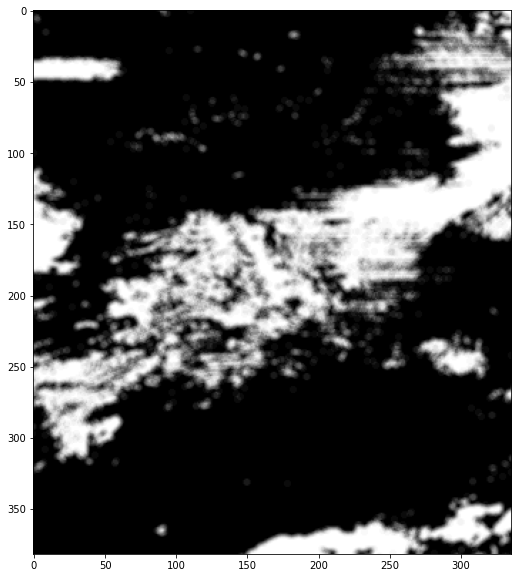

In [72]:
cmap='Greys_r'
plt.figure(figsize=(10, 10))
plt.imshow(data['CF'], vmin=0, cmap=cmap, vmax=1)

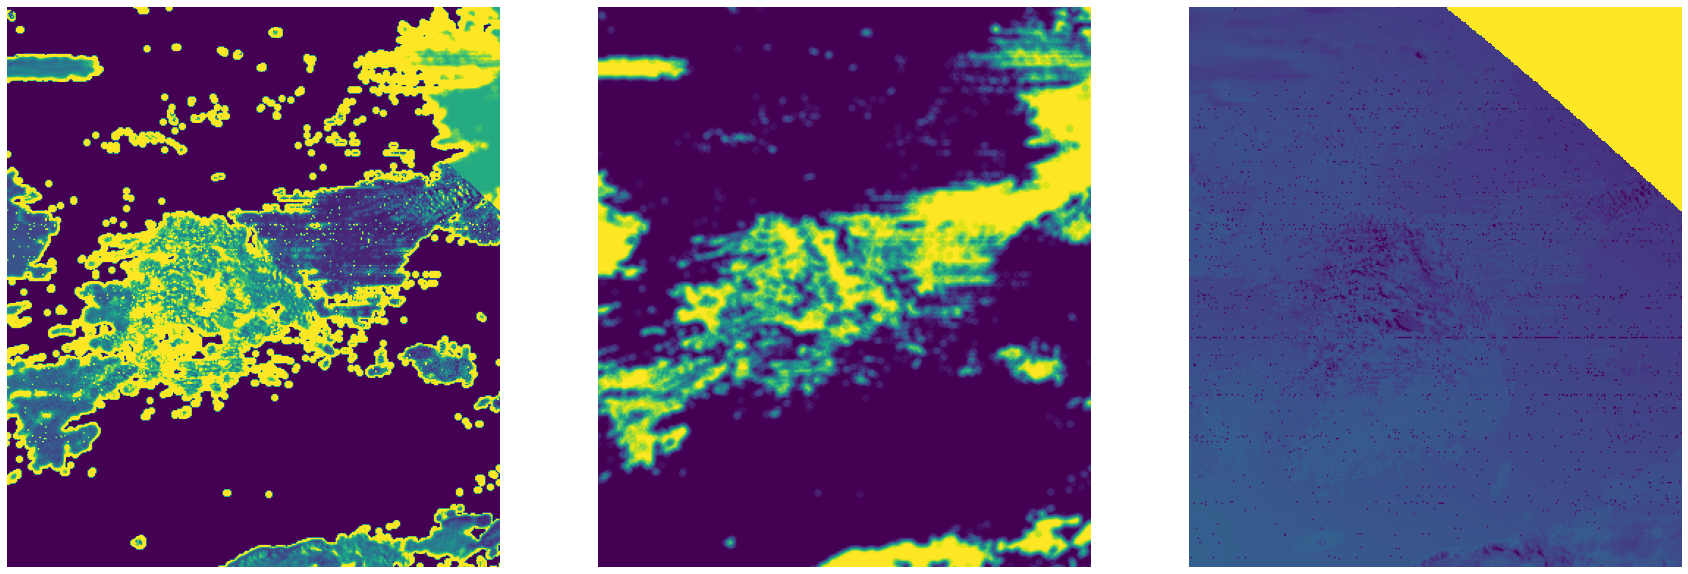

In [73]:
# cmap='Blues'
cmap='viridis'
fig, ax = plt.subplots(1,3)
ax[0].imshow(cloud_albedo, cmap=cmap, vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(data['CF'], vmin=0, cmap=cmap, vmax=1)
ax[1].axis('off')
ax[2].imshow(data['DSR'], vmin=0, cmap=cmap, vmax=1000)
ax[2].axis('off')
fig.subplots_adjust(right=4, top=4)

In [ ]:
# cmap='Blues'
cmap='viridis'
fig, ax = plt.subplots(1,3)
ax[0].imshow(cloud_albedo, cmap=cmap, vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(data['CF'], vmin=0, cmap=cmap, vmax=1)
ax[1].axis('off')
ax[2].imshow(data['DSR'], vmin=0, cmap=cmap, vmax=1000)
ax[2].axis('off')
fig.subplots_adjust(right=4, top=4)

In [106]:
data_output['CAL'][data['CF'] == 0] = 0

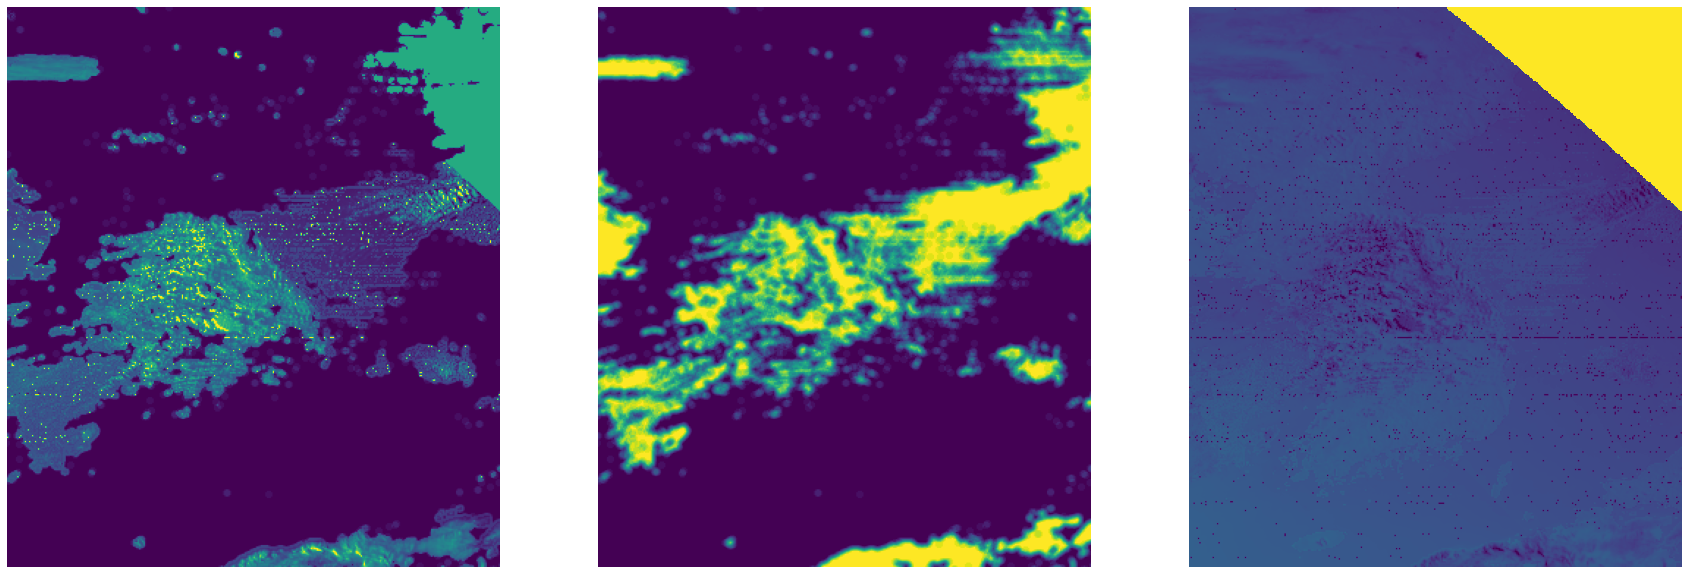

In [ ]:
# cmap='Blues'
cmap='viridis'
fig, ax = plt.subplots(1,3)
ax[0].imshow(data_output['CAL'], cmap=cmap, vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(data['CF'], vmin=0, cmap=cmap, vmax=1)
ax[1].axis('off')
ax[2].imshow(data['DSR'], vmin=0, cmap=cmap, vmax=1000)
ax[2].axis('off')
fig.subplots_adjust(right=4, top=4)

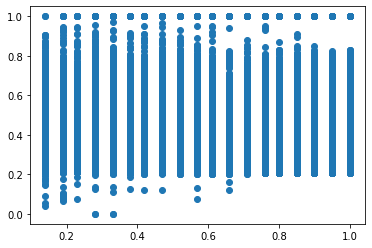

In [148]:
plt.scatter(data['CF'][data['CF']>0.1], np.clip(data['CAL'][data['CF']>0.1], 0, 1))

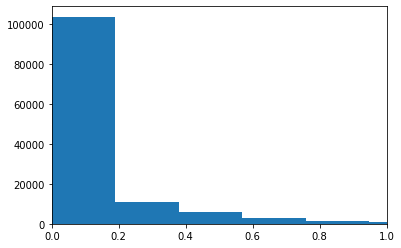

In [152]:
plt.hist(cloud_albedo.flatten(), bins=100)
plt.xlim([0, 1])
plt.show()

In [153]:
np.clip

<function numpy.clip(a, a_min, a_max, out=None)>

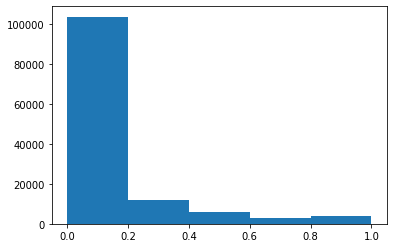

In [155]:
plt.hist(np.clip(cloud_albedo.flatten(), 0, 1), bins=5)
plt.show()

In [16]:
cla_ds.filepath()

'/mnt/sda1/research/data/tmp_gk2a/gk2a_ami_le2_cla_fd020ge_202111180550.nc'

In [156]:
cloud_albedo = np.clip(cloud_albedo, 0, 1)

## save

In [141]:
import json

In [190]:
var_name = 'cloudalbedo'

In [193]:
cur_data = data_output['CAL']

In [158]:
output = {
    'dtype': str(cur_data.dtype),
    'shape': cur_data.shape,
    'data': base64.b64encode(cur_data).decode('utf8')
}

In [191]:
with open(f'gk2a_{var_name}_{obs_datetime}.json', 'w') as f:
    json.dump(output, f)

In [147]:
s = base64.b64encode(data_output['CAL'])
ss = s.decode('utf-8')

In [148]:
data = {'data': ss}

In [21]:
with open('data.json', 'w') as f:
    json.dump(data, f)

## read

In [195]:
with open(f'gk2a_{var_name}_{obs_datetime}.json', 'r') as f:
    loaded_output = json.load(f)

In [196]:
loaded_output.keys()

dict_keys(['dtype', 'shape', 'data'])

In [185]:
restored = np.frombuffer(    
    base64.decodebytes(
        loaded_output['data'].encode('utf-8')
    ), dtype=loaded_output['dtype']
).reshape(output['shape'])


In [186]:
restored.shape

(382, 336)

In [26]:
from PIL import Image

In [162]:
img = Image.fromarray(np.uint8(data['CF']*255), mode='L')

In [163]:
# rgba = img.convert("RGBA")
# datas = rgba.getdata()
  
# newData = []
# for item in datas:
#     if item[0] == 0 and item[1] == 0 and item[2] == 0:  # finding black colour by its RGB value
#         # storing a transparent value when we find a black colour
#         newData.append((255, 255, 255, 0))
#     if 
#     else:
#         newData.append(item)  # other colours remain unchanged
# rgba.putdata(newData)

In [164]:
rgba = img.convert("RGBA")
datas = rgba.getdata()
  
newData = []
for item in datas:
    if item[0] == 0:  # finding black colour by its RGB value
        # storing a transparent value when we find a black colour
        newData.append((0, 0, 0, 0))
    elif item[0] < 15:
        newData.append((15, 15, 15, 15))
    elif item[0] < 31:
        newData.append((31, 31, 31, 31))
    elif item[0] < 47:
        newData.append((47, 47, 47, 47))
    elif item[0] < 63:
        newData.append((63, 63, 63, 63))
    elif item[0] < 79:
        newData.append((79, 79, 79, 79))
    elif item[0] < 95:
        newData.append((95, 95, 95, 95))
    elif item[0] < 111:
        newData.append((111, 111, 111, 111))
    elif item[0] < 127:
        newData.append((127, 127, 127, 127))
    elif item[0] < 143:
        newData.append((143, 143, 143, 143))
    elif item[0] < 159:
        newData.append((159, 159, 159, 159))
    elif item[0] < 175:
        newData.append((175, 175, 175, 175))
    elif item[0] < 191:
        newData.append((191, 191, 191, 191))
    elif item[0] < 207:
        newData.append((207, 207, 207, 207))
    elif item[0] < 223:
        newData.append((223, 223, 223, 223))
    elif item[0] < 239:
        newData.append((239, 239, 239, 239))
    elif item[0] <= 255:
        newData.append((255, 255, 255, 255))
    else:
        newData.append(item)  # other colours remain unchanged
rgba.putdata(newData)

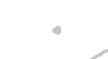

In [165]:
rgba

In [166]:
rgba.save('tmp.png', 'PNG')

In [70]:
item

(71, 71, 71, 255)

In [ ]:
#     0,
#     'rgba(0, 0, 0, 0.0)',
#     15,
#     'rgba(15, 15, 15, 0.0625)',
#     31,
#     'rgba(31, 31, 31, 0.125)',
#     47,
#     'rgba(47, 47, 47, 0.1875)',
#     63,
#     'rgba(63, 63, 63, 0.25)',
#     79,
#     'rgba(79, 79, 79, 0.3125)',
#     95,
#     'rgba(95, 95, 95, 0.375)',
#     111,
#     'rgba(111, 111, 111, 0.4375)',
#     127,
#     'rgba(127, 127, 127, 0.5)',
#     143,
#     'rgba(143, 143, 143, 0.5625)',
#     159,
#     'rgba(159, 159, 159, 0.625)',
#     175,
#     'rgba(175, 175, 175, 0.6875)',
#     191,
#     'rgba(191, 191, 191, 0.75)',
#     207,
#     'rgba(207, 207, 207, 0.8125)',
#     223,
#     'rgba(223, 223, 223, 0.875)',
#     239,
#     'rgba(239, 239, 239, 0.9375)',
#     255,
#     'rgba(255, 255, 255, 1.0)',
# ]